In [3]:
#del(tde_functions)

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import velocity_estimation.two_dim_velocity_estimates as tdve
import velocity_estimation.utils as u
import velocity_estimation.time_delay_estimation as td
from fppanalysis.running_moments import window_radius, run_norm_ds, run_mean_ds
import cosmoplots
import tde_functions

#### Open dataset

In [17]:
shot = 1160616026
#ds = xr.open_dataset("Path to your apd data")
ds = xr.open_dataset("/home/helgeland/data/raw_apd_data/apd_signal_array_1160929017.nc")

#### Extract dead pixels from mds tree

In [18]:
#dead_pix_arr = tde_functions.dead_pixel_finder(shot, dead_pixel_path="Path to your dead pixel file")
dead_pix_arr = tde_functions.dead_pixel_finder(shot, foldername="/home/helgeland/data/dead_pixels/")
print(dead_pix_arr)

[[False False  True False False False False False False]
 [ True  True False False False False False False False]
 [False  True False  True False False False False  True]
 [False False False False False False False  True False]
 [False False False False False False False False  True]
 [ True False False False False False False False  True]
 [False False False  True False False False False False]
 [ True False False False  True False False False  True]
 [False False False False False False False  True  True]
 [ True  True False  True False False  True  True  True]]


#### Remove dead pixels

In [19]:
path_dead_pixel = Path('/home/helgeland/data/dead_pixels/')
dead_pix = np.load(
    str(path_dead_pixel)
    + "/"
    + f"dead_pixels_shot_{shot}.npz"
)
dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
for y in range(dead_pix_arr_ds.shape[0]):
    for x in range(dead_pix_arr_ds.shape[1]):
        if dead_pix_arr_ds[9-y, x]:
            ds['frames'].loc[dict(y=y, x=x)] = np.nan

In [9]:
print(dead_pix_arr)

[[False False  True False False False False False  True]
 [ True  True False False False False False False  True]
 [False  True False  True False False False False  True]
 [False False False False False False False  True  True]
 [False False False False False False False False  True]
 [ True False False False False False False False  True]
 [False False False  True False False False False  True]
 [ True False False False  True False False False  True]
 [False False False False False False False False  True]
 [ True  True False  True False False  True  True  True]]


#### For a given start and end time, slice the dataset

In [20]:
t_start = 1.15
t_end = 1.45
sliced_ds = ds.sel(time=slice(t_start, t_end))

#### Detrend data

In [21]:
cut_off_freq = 1e3
radius = window_radius(cut_off_freq, sliced_ds.time)
ds = run_norm_ds(sliced_ds, radius)
#ds = run_mean_ds(ds, 3)

#### Extract LCFS and limiter positions from mds tree

In [22]:
R_LCFS_mean, R_LCFS_min, R_LCFS_max, Z_LCFS, R_limiter, Z_limiter = tde_functions.LCFS_limiter_positions(
    shot, 
    t_start, 
    t_end, 
    num_time_steps=50, 
    foldername=None
)

shot 1160616026 is complete


#### Estimation options for velocity estimation

In [23]:
eo = tdve.EstimationOptions()
eo.use_3point_method = True
eo.cc_options.running_mean = True
eo.cc_options.minimum_cc_value = 0
eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=0, max_separation=1, min_separation=1)

#### Generate velocities

In [24]:
movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()

/usr/local/lib/python3.10/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Issues estimating velocity for pixel 2 7 Run estimate_velocities_for_pixel(i, j, ds, eo) to get a detailed error stacktrace


/usr/local/lib/python3.10/dist-packages/velocity_estimation/time_delay_estimation.py:609: UserWarning: Maximum running window achieved between pixels (0, 8) and (1, 8)
  warnings.warn("Maximum running window achieved " + extra_debug_info)


#### Plot velocity field

Text(0.59, 1.01, 'time = 1.15 - 1.45 s')

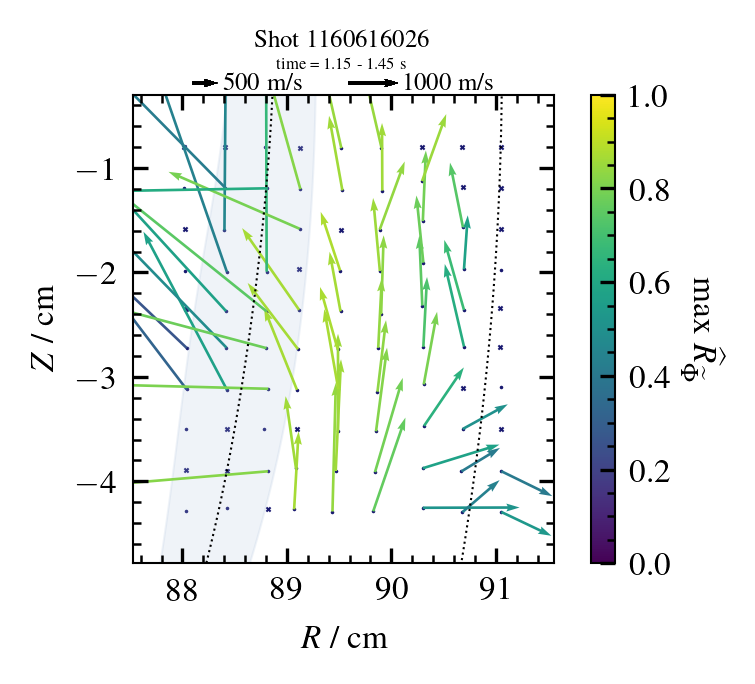

In [25]:
    axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
    plt.rcParams["mathtext.fontset"] = "custom"

    fig = plt.figure()
    ax = fig.add_axes(axes_size)
 
    # Mark dead and alive pixels
    true_indices = np.where(dead_pix_arr)
    false_indices = np.where(dead_pix_arr == False)
    dead_pixels_R = R[true_indices]
    dead_pixles_Z = Z[true_indices]
    alive_pixels_R = R[false_indices]
    alive_pixels_Z = Z[false_indices]

    # Define the default vmin and vmax values
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # Plot dead and alive pixels
    ax.scatter(dead_pixels_R, dead_pixles_Z, marker='x', color='midnightblue', s=1, linewidth=0.5)
    ax.scatter(alive_pixels_R, alive_pixels_Z, marker=".", color='midnightblue', s=0.5)
  
    # Load LCFS and limiter data
    #LCFS_limiter_data = np.load(LCFS_limiter_foldername)
    #R_limiter = LCFS_limiter_data['R_limiter']
    #Z_limiter = LCFS_limiter_data['Z_limiter']
    #R_LCFS = LCFS_limiter_data['R_LCFS']
    #Z_LCFS = LCFS_limiter_data['Z_LCFS']
    #R_LCFS_mean = LCFS_limiter_data['R_LCFS_mean']
    #R_LCFS_min = LCFS_limiter_data['R_LCFS_min']
    #R_LCFS_max = LCFS_limiter_data['R_LCFS_max']

    # Plot LCFS and limiter
    ax.plot(R_LCFS_mean, Z_LCFS, color="black", linestyle=":", linewidth=0.5)
    ax.plot(R_limiter, Z_limiter, color="black", linestyle=":", linewidth=0.5)
    ax.fill_betweenx(
        Z_LCFS.ravel(),
        R_LCFS_min.ravel(),
        R_LCFS_max.ravel(),
        alpha=0.2,
        color="lightsteelblue",
    )

    # Plot the velocity field
    qiv = ax.quiver(
        R,
        Z,
        vx,
        vy,
        confidences,
        scale=210000,
        scale_units="xy",
        angles="xy",
        norm=norm,
    )

    # Plot arrows representing magnitude
    qk = ax.quiverkey(
        qiv, 0.63, 1.025, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
    )
    qk = ax.quiverkey(
        qiv, 0.2, 1.025, 50000, r"$500$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
    )

    # Plot colorbar
    cbar = fig.colorbar(qiv, format="%.1f")
    cbar.ax.set_ylabel(r"max $\widehat{R}_{\widetilde{{\Phi}}}$", rotation=270, labelpad=13)

    ax.set_xlabel(r"$R$ / cm")
    ax.set_ylabel(r"$Z$ / cm")
    ax.set_aspect("equal")
    ax.set_ylim(min(Z[:,0]) - 0.5, max(Z[:,0] + 0.5))
    ax.set_xlim([min(R[0]) - 0.5, max(R[0]) + 0.5])
    plt.xticks(np.arange(round(min(R[0])), round(max(R[0]))+1, 1))
    plt.yticks(np.arange(round(min(Z[:,0])), round(max(Z[:,0]))+1, 1))
    ax.set_title(rf"Shot {shot}" , fontsize=6,  x=0.5, y=1.05)
    plt.suptitle(r'time = 'f'{t_start} - {t_end} s', fontsize=4, horizontalalignment='center', x=0.59, y=1.01)
